# Interlayer PLSR

The plan:
1. get multi-layer activations for validation set
1. get multi-layer activations for task datasets
1. calculate PCs from valid_acts for both layers
1. use the PCs from layer1 as our dependent variable and the activation space of layer0 as our multivariate input independent variable and perform PLSR
1. take the resulting layer0 PLSR components and see how they overlap with PC components from layer0
1. maybe we can produce some groupings of the layer0 PCs from this process

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1922977544
set_all_seeds(seed)
print(seed)

2976289299


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


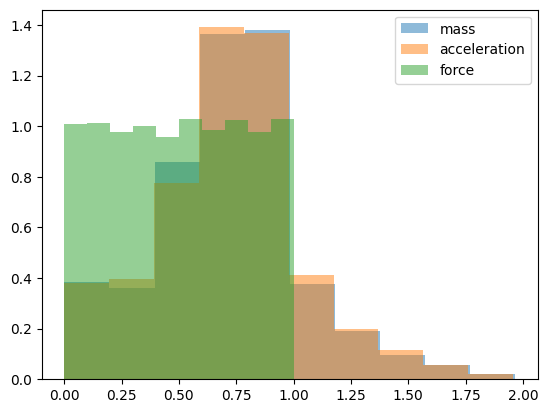

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

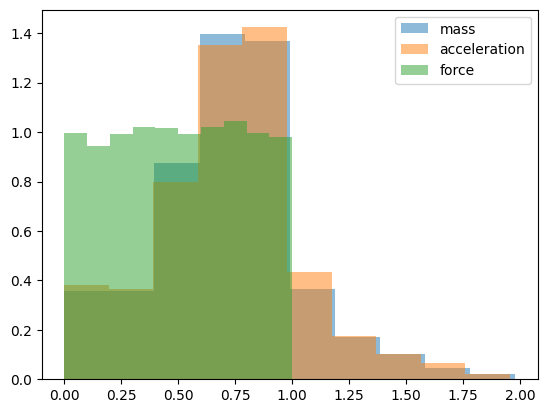

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

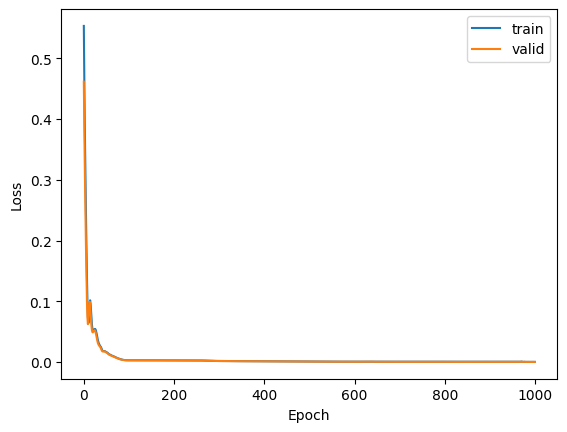

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0003)

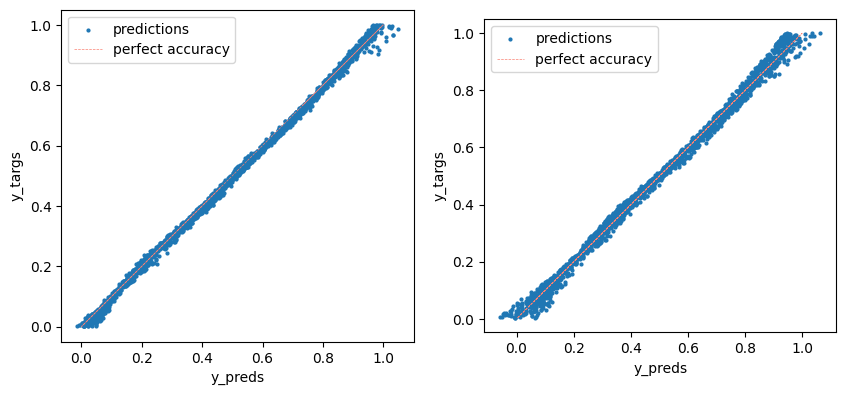

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [17]:
valid_ios = capture_intermediate_outputs(model, X_valid)
task_ios = capture_intermediate_outputs(model, task_inputs)

Now we'd like to compare the principal components at `layers.0.act` with those from `layers.1.act` I think.

In [18]:
def get_pcs(data):
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances

In [19]:
task_acts = {}
task_acts["0"] = task_ios["layers.0.act"]
task_acts["1"] = task_ios["layers.1.act"]
task_acts["0"].shape, task_acts["1"].shape

(torch.Size([20000, 16]), torch.Size([20000, 16]))

In [20]:
valid_acts = {}
valid_acts["0"] = valid_ios["layers.0.act"]
valid_acts["1"] = valid_ios["layers.1.act"]
valid_acts["0"].shape, valid_acts["1"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [21]:
valid_pcs = {}
valid_vars = {}
valid_pcs["0"], valid_vars["0"] = get_pcs(valid_acts["0"])
valid_pcs["1"], valid_vars["1"] = get_pcs(valid_acts["1"])
valid_pcs["0"].shape, valid_pcs["1"].shape

(torch.Size([16, 16]), torch.Size([16, 16]))

In [22]:
def get_pc_acts(pcs, acts):
    pc_acts = (pcs.T[None, :] * acts[:, None, :]).sum(-1)
    return pc_acts

In [23]:
valid_pc_acts = {}
valid_pc_acts["0"] = get_pc_acts(valid_pcs["0"], valid_acts["0"])
valid_pc_acts["1"] = get_pc_acts(valid_pcs["1"], valid_acts["1"])
valid_pc_acts["0"].shape, valid_pc_acts["1"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [24]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

# Assuming `x_tensor` and `y_tensor` are your PyTorch tensors for X and Y

# Convert PyTorch tensors to NumPy arrays
X = valid_acts["0"].numpy()
Y = valid_acts["1"].numpy()

# Standardize the data (optional but recommended)
scaler_x = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(Y)
X_scaled = scaler_x.transform(X)
Y_scaled = scaler_y.transform(Y)

pls = PLSRegression(n_components=16)
pls.fit(X_scaled, Y_scaled)

# Weights for X
X_weights = pls.x_weights_  # Shape will be (16, 16) if X has 16 features

# Weights for Y
Y_weights = pls.y_weights_  # Shape will be (16, 16) if Y has 16 features

Ok, now we have components in the `layer0` activation space that cause the greatest variance in a second set of components in the `layer1` activation space. The PLSR algorithm probably assumes some linear relationship which is _almost_ true except we have a ReLU non-linearity - I'm hoping it still does an ok job.

[Due to a quirk in the `sklearn` implementation of PLSR](https://stats.stackexchange.com/questions/523754/what-is-the-plsr-implementation-in-sklearn), the y_weights are not normalised 🤷 but the x_weights are.

In [25]:
np.linalg.norm(X_weights, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
np.linalg.norm(Y_weights, axis=0)

array([9.24003992e-01, 8.20675240e-01, 7.06589251e-01, 3.31502235e-01,
       7.86407831e-01, 3.56082943e-01, 2.90895190e-01, 2.80044643e-01,
       4.68673504e-01, 3.91005528e-01, 1.85942076e+00, 1.17478271e+00,
       6.28970769e-01, 1.55419282e+12, 1.31140532e+12, 2.53131790e+12])

In [27]:
valid_plsrs = {}
valid_plsrs["0"] = torch.from_numpy(X_weights).float()
valid_plsrs["1"] = torch.from_numpy(Y_weights)
valid_plsrs["1"] = (valid_plsrs["1"] / torch.norm(valid_plsrs["1"], dim=0)).float()

So I suppose now the test is to see how these components relate to the principal components extracted from PCA. My working hypothesis is that whilst I don't expect the PLSR components to be completely aligned with the PCA components, I expect them to potentially overlap in a way that clusters between tasks e.g. PLSR component 1 in the input space can be described by a linear combination of task-specific components from PCA.

I'm pretty unsure here though.

In [28]:
valid_plsrs["0"].shape, valid_pcs["0"].shape

(torch.Size([16, 16]), torch.Size([16, 16]))

In [29]:
sims = torch.einsum("ij,ik->jk", valid_plsrs["0"], valid_pcs["0"]).numpy()

In [30]:
def plot_similarity(sims, title="Dot-product Similarity", x_label=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("PCA Components", fontsize=14)
    ax.set_ylabel("PLSR Components", fontsize=14)

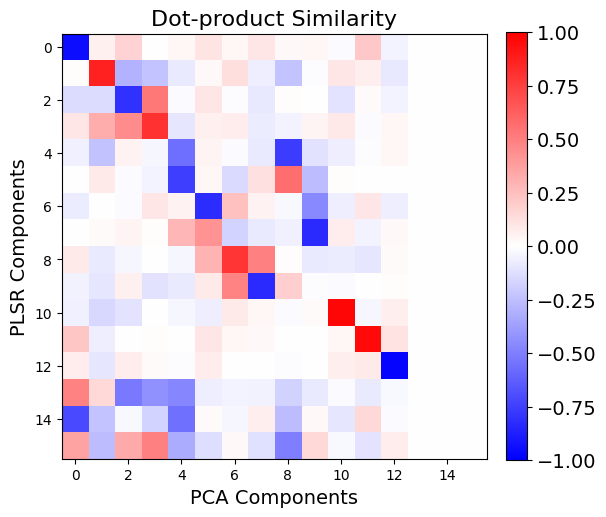

In [31]:
plot_similarity(sims)

Here is the similarity matrix between **some random vectors for comparison:**

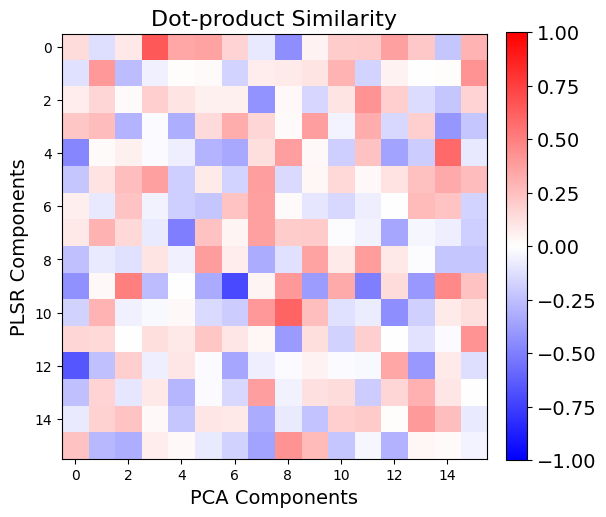

In [32]:
cont_comps_A = torch.rand((16, 16)) * 2 - 1
cont_comps_A = cont_comps_A / torch.norm(cont_comps_A, dim=0)
cont_comps_B = torch.rand((16, 16)) * 2 - 1
cont_comps_B = cont_comps_B / torch.norm(cont_comps_B, dim=0)

cont_sims = torch.einsum("ij,ik->jk", cont_comps_A, cont_comps_B).numpy()

plot_similarity(cont_sims)

So, this still needs some picking apart but it looks like good news to me:
- Lots of structure in the similarity matrices between the PLSR and PCA components. This means there is _some_ relationship between them (which we might have expected).
- It's often quite diagonal, this suggests that high variance components in the layer0 output space also go on to produce high-variance components in the layer1 output space. At first this seems to me to suggest that the layer might not be doing so much but I think there's some more subtle thinking to do here.
- There are some little off-diagonal clusters that form. I'm hoping these make sense task-wise.
- There always appears some non-orthogonality in the low-variance PLSR / high-variance PCA region. Given that each set of components is an orthonormal basis, this suggests that some of the information in the high-variance components from layer0 is not used or at least does not result in variance in the output of layer1. This could be some noise-reduction strategy - a way to ignore/correct unhelpful/misleading information from layer0. Would be interesting to think about this.

Now I need to think of a way of viewing this information in a task-specific way.

I think I'm going to do the same as before and just make those plots of explained variance in each task as well as the proportion of variance capture by each component.

In [33]:
valid_plsr_task_acts = (
    {}
)  # i.e. the task set activations when we dot them with the PLSR components from the valid set
valid_plsr_task_acts["0"] = get_pc_acts(valid_plsrs["0"], task_acts["0"])
valid_plsr_task_acts["1"] = get_pc_acts(valid_plsrs["1"], task_acts["1"])

In [34]:
def plot_pca_variances(varA, varB, err_varA=None, err_varB=None):
    _, ax = plt.subplots(figsize=(6, 6))

    # plot the variances for task A
    ax.bar(range(len(varA)), varA, yerr=err_varA, label="Task A activations", alpha=0.5)
    ax.bar(range(len(varB)), varB, yerr=err_varB, label="Task B activations", alpha=0.5)
    ax.set_xlabel("PLSR Component")
    ax.set_ylabel("Variance")
    ax.set_title(
        "Variance of PLSR components from validation set\nfor activations of each task in the task dataset"
    )
    ax.legend()

In [35]:
sliceA = slice(0, 10000)
sliceB = slice(10000, None)
varA = torch.var(valid_plsr_task_acts["0"][sliceA], dim=0)
varB = torch.var(valid_plsr_task_acts["0"][sliceB], dim=0)

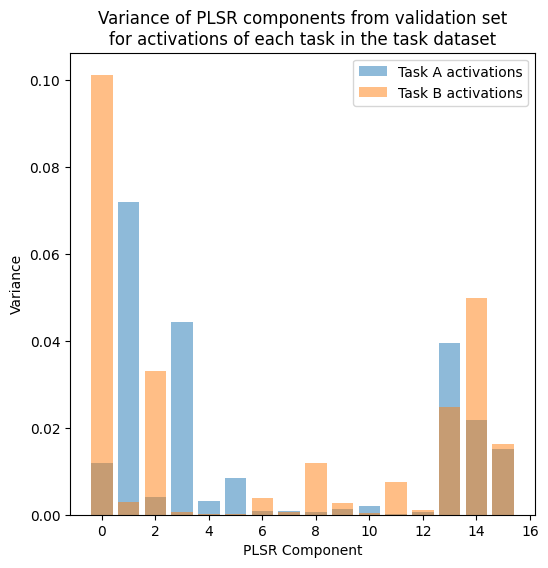

In [36]:
plot_pca_variances(varA, varB, err_varA=None, err_varB=None)

Ok nice, so I think we see a similar picture to before which is good! With this in mind though, if we start to think about drawing graphs of important components, we're going to quickly get unstuck because, as we see, there are lots of high-variance resulting components that won't get used by the next layer. How do we meaningfully represent this in a graph? Each output node is only going to be partially used by the next layer.

Ok so I think a nice idea would be to:
- Create a graph with two sets of nodes for each layer
    - one is the output space for that layer - formed from doing PLSR with that layer and layer before
    - the next would be the input space for the next layer - formed from doing PLSR with this layer's outputs and the outputs of the next layer
- The intra-layer weights, i.e. those between the two layers mentioned above, would represent how the following layer is accessing the outputs of the current layer, where it's looking in the space.
- This way, we'd see how principal components from a previous layer are split or combined in the next layer
- The question of how to represent the different tasks is a little tricky, I suppose it could be multi-dimensional weights. OR one could create one of those flow diagrams people use in finance but where the flow weight/width is actually the variance explained for each task.
- Could think about ordering/clustering the nodes in terms of which task they are representing

Ideas: 
- look at the relationship between task orthogonality and loss
- think about whether the low-variance PLSR components are the ones that end up being "denoised" by the ReLU activations